# Week 8: Denoising Diffusion Models (DDPMs and DDIMs)

Welcome to this Week 8 hands-on tutorial! In this notebook, we’ll explore how to train Denoising Diffusion Probabilistic Models (DDPMs) using **PyTorch**. These models are powerful tools for generating high-quality data samples by iteratively denoising a noisy input.

For this task, we will build and train a **Denoising Diffusion Model. Diffusion models[1,2] can be understood as a type of Hierarchical Variational Autoencoder. The framework consists of two trajectories:  

1. **Bottom-Up Trajectory (Variational Posterior)**  
   - Characterized by a diffusion process, such as Gaussian diffusion.  
   - This path introduces Gaussian noise at each layer, eventually transforming the latent variable into a standard Gaussian distribution.  
   - This trajectory can be fixed and does not require learnable parameters.

2. **Top-Down Trajectory**  
   - Parameterized by deep neural networks to represent the reversed diffusion process.  

The explicit design of the bottom-up path ensures convergence to a standard Gaussian in the last layer, inherently avoiding the issue of posterior collapse.

To accelerate the sampling process, we will use both the original DDPM sampler and the **Denoising Diffusion Implicit Models (DDIM)** sampler. The DDIM sampler provides a more efficient way to generate samples by reducing the number of denoising steps required.

By the end of this notebook, you’ll understand how to:
1. Build and train a DDPM using PyTorch.
2. Implement and use the original DDPM sampler to generate data samples.
3. Implement and use the DDIM sampler to accelerate the sampling process.

Let’s dive in and start building!

---

#### References
<div style="font-size: smaller;">  
[1] Sohl-Dickstein, J., Weiss, E., Maheswaranathan, N., & Ganguli, S. (2015, June). Deep unsupervised learning using nonequilibrium thermodynamics. In International conference on machine learning (pp. 2256-2265). PMLR.

[2] Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models. Advances in neural information processing systems, 33, 6840-6851.
</div>

### Step 1: Import Libraries and Create a Dataset of 2D Points

In this step, we will import the necessary libraries and create a dataset of 2D points that form a smiley face. This dataset will be used to train our Denoising Diffusion Model. Using a simpler dataset reduces the computational requirements of this notebook, but allow for a better visual representation of how these models work.

In [65]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

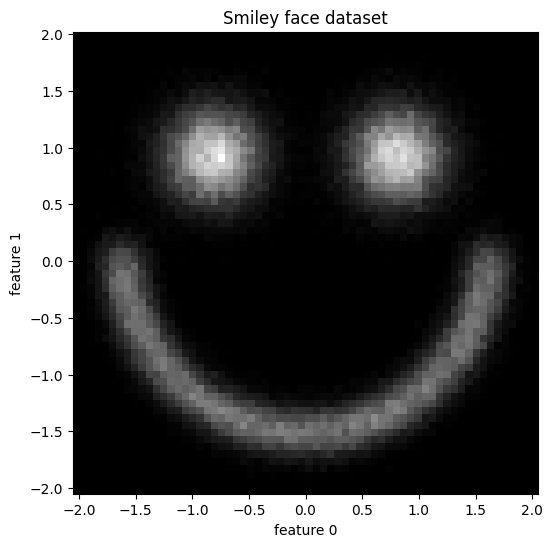

In [66]:
### Code based on https://bm371613.github.io/conditional-flow-matching/ ###

def create_dataset(size: int = 100000):
    '''
    Create a dataset of size `size` of 2D points that have a shape of a smiley face.
    Args:
        size: int: The number of points to generate.
    Returns:
        torch.Tensor: The generated dataset.
    '''
    complex_points = torch.polar(torch.tensor(1.0), torch.rand(size) * 2 * torch.pi)
    X = torch.stack((complex_points.real, complex_points.imag)).T
    upper = complex_points.imag > 0
    left = complex_points.real < 0
    X[upper, 1] = 0.5
    X[upper & left, 0] = -0.5
    X[upper & ~left, 0] = 0.5
    noise = torch.zeros_like(X)
    noise[upper] = torch.randn_like(noise[upper]) * 0.10
    noise[~upper] = torch.randn_like(noise[~upper]) * 0.05
    X += noise
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    return X + noise

def plot_dataset(X, bins, ax=None, verbose=True, **kwargs):
    '''
    Plot a 2D dataset.
    Args:
        X: torch.Tensor: The dataset to plot.
        bins: int: The number of bins to use for the histogram.
        ax: plt.Axes: The axes to plot on. If None, the current axes will be used.
        verbose: bool: Whether to show the axis labels.
        **kwargs: dict: Additional keyword arguments to pass to `ax.set`.
    '''
    if ax is None:
        ax = plt.gca()
    ax.hist2d(*X.T, bins=bins, cmap='gray')
    if verbose:
        ax.set_xlabel('feature 0')
        ax.set_ylabel('feature 1')
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    ax.set(**kwargs)

# Create the smiley face dataset and plot it.
dataset = create_dataset()
fig = plt.figure(figsize=(6, 6))
plot_dataset(dataset, bins=64, title='Smiley face dataset')

### Step 2: Define a suitable Diffusion Model

1. The main requirement for a model capable of parametrizing these tasks is **Output Dimensionality**:
    - **The model's output must match the input dimensionality**. Each score corresponds directly to each pixel (or input feature), whether it's predicting gradients, noise values, or a vector field.

2. The second requirement is also straightforward an simple to ensure - **the model must take the time step as a conditioning input**.
    - The time step provides information about the diffusion/matching process stage, enabling the model to predict the appropriate scores or noise values.

3. This means that the **Model Architecture is flexible**. While U-Nets are commonly used for high-dimensional inputs like images, you can use any architecture that supports the task. Recent approaches even use transformers.
    - For this notebook, since the distribution we are modelling is not complex, we will use a **Multilayer Perceptron (MLP)** for faster training and inference. 


In [67]:
class ZeroToOneTimeEmbedding(nn.Module):

    def __init__(self, dim: int):
        '''
        Create a time embedding that maps time to a 2D embedding.
        Args:
            dim: int: The dimensionality of the embedding
        '''
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.register_buffer('freqs', torch.arange(1, dim // 2 + 1) * torch.pi)

    def forward(self, t):
        '''
        Forward pass of the time embedding.
        Args:
            t: torch.Tensor: The time to embed.
        Returns:
            torch.Tensor: The embedded time.
        '''
        emb = self.freqs * t[..., None]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    
class MLP(nn.Module):
    def __init__(self, n_features, time_embedding_size=8, n_blocks=5):
        '''
        Create an MLP with residual connections.
        Args:
            n_features: int: The number of input and output features.
            time_embedding_size: int: The size of the time embedding to use.
            n_blocks: int: The number of residual blocks to use.
        '''
        super().__init__()
        self.time_embedding = ZeroToOneTimeEmbedding(time_embedding_size)
        hidden_size = n_features + time_embedding_size
        blocks = []
        for _ in range(n_blocks):
            blocks.append(nn.Sequential(
                nn.BatchNorm1d(hidden_size),  # BatchNorm layer for normalization
                nn.Linear(hidden_size, hidden_size),  # Linear layer
                nn.ReLU(),  
            ))
        self.blocks = nn.ModuleList(blocks)
        self.final = nn.Linear(hidden_size, n_features) 


    def forward(self, X, time):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
            time: torch.Tensor: The time to embed.
        Returns:
            torch.Tensor: The output of the model.
        '''
        X = torch.cat([X, self.time_embedding(time)], axis=1)
        for block in self.blocks:
            X = X + block(X)
        X = self.final(X)
        return X

### Step 3: The Forward Diffusion process

Ho *et al.* introduced a pivotal shift in how the reverse diffusion process is trained, significantly boosting its computational efficiency. Instead of reconstructing the image at a given timestep, the model is trained to predict the noise added during the forward diffusion process. This change simplifies the training objective and aligns with the mathematical properties of the diffusion process.  

In forward diffusion, an input image $x_0$ is progressively corrupted by adding Gaussian noise at each step. The forward distribution for a given timestep \(t\) is defined as  

$$
q(x_t | x_0) = \mathcal{N}(x_t | \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) \mathbf{I}),
$$

where $\alpha_t = 1 - \beta_t, \quad \bar{\alpha}_t = \prod_{s=1}^t \alpha_s.$ This leads to the formulation

$$
x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon},
$$

where  $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ represents Gaussian noise.



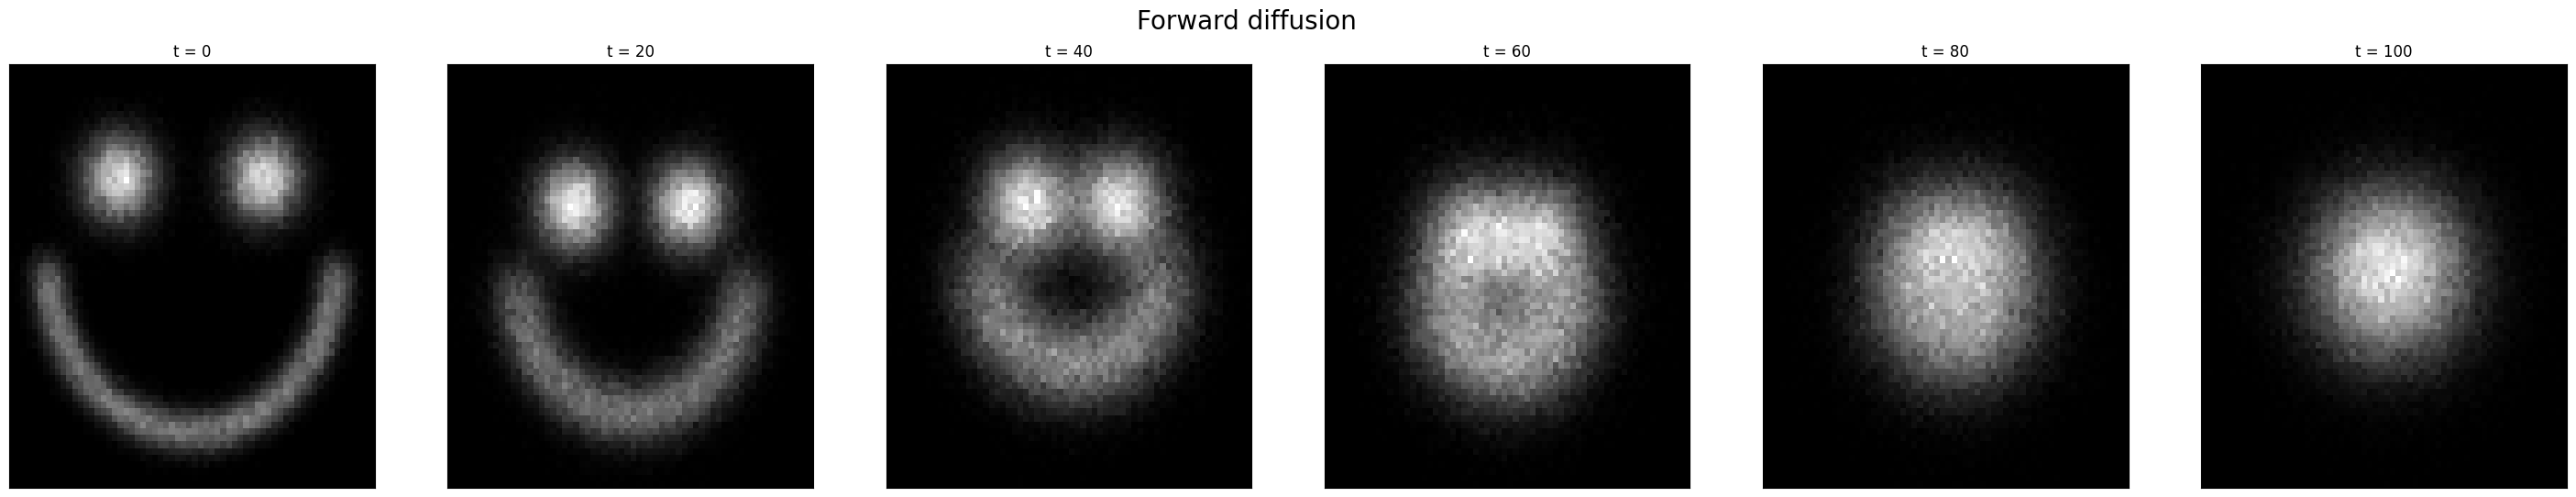

In [69]:
class ForwardDiffusion:
    def __init__(self, beta_1, beta_t, timesteps):
        '''
        Create a forward diffusion model.
        Args:
            beta_1: float: The initial value of beta.
            beta_t: float: The final value of beta.
            timesteps: int: The number of timesteps to use.
        '''
        
        self.betas = torch.linspace(beta_1, beta_t, timesteps)
        
        # Calculate alpha_t and bar_alpha_t
        self.alphas = 1.0 - self.betas
        self.bar_alpha = torch.cumprod(self.alphas, dim=0)
        self.timesteps = timesteps
        

    def sample(self, x, time, noise=None):
        '''
        Sample from the forward diffusion model.
        Args:
            x: torch.Tensor: The input to the model.
            time: torch.Tensor: The time to sample at.
        '''
        if noise is None:
            noise = torch.randn_like(x)
        
        # Ensure time is an integer index and within bounds [0, timesteps-1]
        time_index = min(int(time), self.timesteps - 1)
        
        # Get the value of bar_alpha at the given time index
        bar_alpha_t = self.bar_alpha[time_index]
        
        # Compute the forward diffusion equation:
        # x_t = sqrt(bar_alpha_t) * x + sqrt(1 - bar_alpha_t) * noise
        x_t = torch.sqrt(bar_alpha_t) * x + torch.sqrt(1 - bar_alpha_t) * noise
        return x_t
    
forward = ForwardDiffusion(beta_1=1e-4, beta_t=0.02, timesteps=100)

fig, axs = plt.subplots(1, 6, figsize=(36, 6))

plot_dataset(dataset, bins=64, ax=axs[0], title='t = 0', verbose=False)

for i in range(20,120,20):
    plot_dataset(forward.sample(dataset, i), bins=64, ax=axs[i//20], title=f't = {i}', verbose=False)
fig.suptitle('Forward diffusion', fontsize=20)
plt.show()


### Step 4: Train the Model

Instead of directly predicting the reverse mean $\tilde{\mu}t$, the model predicts the noise $\epsilon_\theta(x_t)$ that corrupts the original data $x_0$. This approach reformulates the problem of learning $\mu_\theta(x_t)$ into predicting the noise $\epsilon$, which simplifies optimization and enhances numerical stability. Thus, the training algorithm is given by

1. **repeat**  
2. &nbsp;&nbsp;&nbsp;Sample $x_0 \sim q(x_0)$  
3. &nbsp;&nbsp;&nbsp;Sample $t \sim \text{Uniform}(\{1, \dots, T\})$  
4. &nbsp;&nbsp;&nbsp;Sample $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$  
5. &nbsp;&nbsp;&nbsp;Take a gradient descent step on $\nabla_\theta \| \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon}, t) \|^2$  
6. **until converged**


In [70]:
def diffusion_loss(model, forward, batch, device='cpu'):
    '''
    Perform a single training step on a batch of data.
    Args:
        model: nn.Module: The model to train.
        forward: ForwardDiffusion: The forward diffusion model to use.
        batch: torch.Tensor: The batch of data to train on.
        device: str: The device to use for training.
    Returns:
        torch.Tensor: The loss of the model on the batch.
    '''
    loss_fn = nn.MSELoss() # The loss function to use, according to step 5 of the algorithm.
    time = torch.randint(low=1, high=forward.timesteps+1, size=(batch.shape[0],))
    noise = torch.randn_like(batch)

    X_t = forward.sample(batch, time, noise=noise)
    normalized_time = time.float()/forward.timesteps # the model expects time to be normalized to [0, 1]

    X_pred = model(X_t.to(device), normalized_time.to(device))

    return loss_fn(X_pred, noise.to(device))

def training_loop(model, forward, n_steps, batch_size, lr):
    '''
    Train a model using the forward diffusion model.
    Args:
        model: nn.Module: The model to train.
        forward: ForwardDiffusion: The forward diffusion model to use.
        n_steps: int: The number of training steps to take.
        batch_size: int: The number of samples in each batch.
        lr: float: The learning rate to use.
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    step_bar = trange(n_steps, desc='Steps')
    for step in step_bar:
        optimizer.zero_grad()
        batch = create_dataset(size=batch_size)
        loss = diffusion_loss(model, forward, batch, device)
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            step_bar.set_postfix({'loss': loss.item()})

model = MLP(n_features=2)
training_loop(model, forward, n_steps=2000, batch_size=10000, lr=1e-1)


Steps:   0%|          | 0/2000 [00:00<?, ?it/s]


ValueError: only one element tensors can be converted to Python scalars

### Step 5: Sample from a DDPM

Sampling in diffusion models involves generating data by reversing the forward diffusion process. Starting with random Gaussian noise, the model iteratively denoises the sample to produce realistic outputs. At each timestep $t$, the process uses the predicted noise $\boldsymbol{\epsilon}_\theta(x_t, t)$ to compute the intermediate state $x_{t-1}$.

1. $x_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$  
2. **for** $t = T, \dots, 1$ **do**  
3. &nbsp;&nbsp;&nbsp;$z \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ if $t > 1$, else $z = 0$  
4. &nbsp;&nbsp;&nbsp;$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \, \boldsymbol{\epsilon}_\theta(x_t, t) \right) + \sigma_t z$  
5. **end for**  
6. **return** $x_0$

For the sake of simplicity, we can isolate some elements of this equation:

$$ c1 = \frac{1}{\sqrt{\alpha_t}} $$

$$ c2 = \frac{1}{\sqrt{\alpha_t}} \cdot \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} $$

so that we have:

$$ x_{t-1} = c1 \cdot x_t - c2 \cdot \boldsymbol{\epsilon}_\theta(x_t, t) + \sigma_t z $$


The standard deviation $\sigma_t$ is kept as $\sqrt{\beta_t}$, which corresponds to the noise schedule defined during training.

In [ ]:
class ReverseDiffusionDDPM:
    def __init__(self, beta_1, beta_t, timesteps, device='cpu'):
        '''
        Create a reverse diffusion model.
        Args:
            beta_1: float: The initial value of beta.
            beta_t: float: The final value of beta.
            timesteps: int: The number of timesteps to use.
            device: str: The device to use for training.
        '''
        self.betas = None # A tensor of shape (timesteps,) ranging from beta_1 to beta_t (same as in the Forward Diffusion process!).
        self.timesteps = timesteps
        self.bar_alpha = None # A tensor of shape (timesteps,) with the bar_alpha values (once again, same as in the Forward Diffusion process!).
        self.alpha = 1 - self.betas
        self.device = device

    @torch.no_grad()    
    def sample(self, n_samples, model):
        '''
        Sample from the reverse diffusion model.
        Args:
            n_samples: int: The number of samples to generate.
            model: nn.Module: The model to use for sampling.
        '''
        model.eval()
        x_t = torch.randn(n_samples, 2)
        x_all = []
        x_all.append(x_t)
        for i in tqdm(range(self.timesteps, 0, -1)):

            c1 = None # The c1 value as defined by the reverse diffusion model.
            c2 = None # The c2 value as defined by the reverse diffusion model.
            sigma = torch.sqrt(self.betas[i-1]) if i > 1 else 0

            # sample noise
            noise = torch.randn(n_samples, 2)

            # normalize time
            t = torch.ones(n_samples)*i/self.timesteps

            # determine x_{t-1}
            x_t = c1*x_t - c2*model(x_t.to(self.device), t.to(self.device)).cpu().detach() + sigma*noise

            x_all.append(x_t)
        return x_all
    
def plot_reverse_diffusion(samples, sample_timesteps):
    '''
    Plot samples from the reverse diffusion model.
    Args:
        samples: list: The samples to plot.
        sample_tiemsteps: int: The number of timesteps used to sample the data.
    '''
    fig, axs = plt.subplots(1, 6, figsize=(36, 6))
    for i in range(0, sample_timesteps + sample_timesteps//5, sample_timesteps//5):
        plot_dataset(samples[i], bins=64, ax=axs[i//(sample_timesteps//5)], title=f't = {sample_timesteps-i}', verbose=False)
    fig.suptitle('Reverse diffusion', fontsize=20)
    plt.show()

reverse = ReverseDiffusionDDPM(beta_1=1e-4, beta_t=0.02, timesteps=100)
dataset_samples = reverse.sample(100000, model)

plot_reverse_diffusion(dataset_samples, reverse.timesteps)


### Step 6: Sample With Fewer Steps using a DDIM

Song *et al.* [3] introduced Denoising Diffusion Implicit Models (DDIMs), a more efficient class of iterative implicit probabilistic models with the same training procedure as DDPMs, that can accelerate sampling by up to 10 times. From $p_\theta(x_{1:T})$, one can generate a sample $x_{t-1}$ from a given sample $x_t$ as:

$$
x_{t-1} = \underbrace{\sqrt{\bar{\alpha}_{t-1}} \left( \frac{x_t - \sqrt{1 - \bar{\alpha}_t} \, \boldsymbol{\epsilon}_\theta(x_t)}{\sqrt{\bar{\alpha}_t}} \right)}_{\text{"predicted } x_0\text{"}} 
+ \underbrace{\sqrt{1 - \bar{\alpha}_{t-1} - \sigma_t^2} \cdot \boldsymbol{\epsilon}_\theta(x_t)}_{\text{"direction pointing to } x_t\text{"}} 
+ \underbrace{\sigma_t \boldsymbol{\epsilon}_t}_{\text{"random noise"}}
$$

where $\boldsymbol{\epsilon}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ is standard Gaussian noise independent of $x_t$, and $\bar{\alpha}_0 := 1$. Different choices of $\sigma_t$ result in different generative processes, all while using the same model $\boldsymbol{\epsilon}_\theta$, meaning re-training the model is unnecessary.

### Special Cases of $\sigma_t$:
1. **DDPM (Denoising Diffusion Probabilistic Model):**  
   When $\sigma_t = \sqrt{\frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \frac{1 - \bar{\alpha}_t}{\bar{\alpha}_{t-1}}}$, the forward process becomes Markovian, and the generative process becomes a standard DDPM.

2. **DDIM (Denoising Diffusion Implicit Model):**  
   When $\sigma_t = 0$ for all $t$, the forward process becomes deterministic, meaning that given $x_{t-1}$ and $x_0$, the process is deterministic except at $t=1$. The generative process skips adding random noise, and the coefficient of $\boldsymbol{\epsilon}_t$ becomes zero. This results in an *implicit probabilistic model* (as described by Mohamed & Lakshminarayanan, 2016).  

   The DDIM retains the DDPM training objective but with a deterministic forward process. Samples are generated from latent variables using a fixed procedure, transitioning from $x_T$ to $x_0$.

---

#### References
<div style="font-size: smaller;">  
[3] Song, J., Meng, C., & Ermon, S. Denoising Diffusion Implicit Models. In International Conference on Learning Representations.
</div>

In [ ]:
class ReverseDiffusionDDIM:
    def __init__(self, beta_1, beta_t, timesteps, sample_timesteps, device='cpu'):
        '''
        Create a reverse diffusion model.
        Args:
            beta_1: float: The initial value of beta.
            beta_t: float: The final value of beta.
            timesteps: int: The number of timesteps to use.
            sample_timesteps: int: The number of timesteps to sample at.
            device: str: The device to use for training.
        '''
        self.betas = None # A tensor of shape (timesteps,) ranging from beta_1 to beta_t (same as in the Forward Diffusion process!).
        self.timesteps = timesteps
        self.sample_timesteps = sample_timesteps
        self.scaling = self.timesteps // self.sample_timesteps
        self.bar_alpha = None # A tensor of shape (timesteps,) with the bar_alpha values (once again, same as in the Forward Diffusion process!).
        self.device = device

    @torch.no_grad()    
    def sample(self, n_samples, model):
        '''
        Sample from the reverse diffusion model.
        Args:
            n_samples: int: The number of samples to generate.
            model: nn.Module: The model to use for sampling.
        '''
        model.eval()
        x_t = torch.randn(n_samples, 2)
        x_all = []
        x_all.append(x_t)

        # we start at the last timestep and go backwards skipping some steps with the scaling factor
        for i in tqdm(range(self.timesteps, 0, -self.scaling)):

            if i == self.scaling:
                # the last step is not 1, so we need to correct for that
                alpha_t_minus_1 = torch.tensor(1.0)
            else:
                alpha_t_minus_1 = None # The alpha_{t-1} value as defined by the reverse DDIM diffusion model.

            # the predicted noise for the current timestep
            eps = model(x_t.to(self.device), torch.ones(n_samples)*i/self.timesteps).cpu().detach()

            x_0 = None # The x_0 value as defined by the reverse DDIM diffusion model.
            x_t_dir = None # The direction pointing to x_t value as defined by the reverse DDIM diffusion model.

            # the prediced x_{t-1} value
            x_t = x_0 + x_t_dir
            x_all.append(x_t)
        return x_all

reverse = ReverseDiffusionDDIM(beta_1=1e-4, beta_t=0.02, timesteps=100, sample_timesteps=20)
dataset_samples = reverse.sample(100000, model)

plot_reverse_diffusion(dataset_samples, reverse.sample_timesteps)